In [730]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate mock data for tasks and robots
def generate_mock_data():
    task_durations = [x for x in range(11)]# Task durations
    task_priorities = [x for x in range(11)]   # Task priorities
    robot_efficiencies = [0.1,0.01,0.2,0.3,0.4] # Robot efficiencies
    return task_durations, task_priorities, robot_efficiencies
    

In [731]:

def fitness_function( assignment, task_durations, task_priorities, robot_efficiencies):

    # Calculate the total duration of tasks assigned to each robot
    robot_workloads = [0] * len(robot_efficiencies)
    for task, robot in enumerate(assignment):
        robot_workloads[robot] += task_durations[task] * task_priorities[task] / robot_efficiencies[robot]

    # Calculate the total time taken to complete all tasks
    T_total = max(robot_workloads)

    # Calculate the workload distribution among robots
    workload_distribution = np.std(robot_workloads)

    # Calculate the fitness value
    fitness = 1 / (T_total + workload_distribution)

    return fitness

def select_parents(population, fitness_values, pop_size, num_tasks, tournament_size=3):
    #! i dont understand this function
    parents = np.empty((pop_size, num_tasks), dtype=int)
    for i in range(pop_size):
        tournament_indices = np.random.choice(pop_size, tournament_size, replace=False)
        best_parent_idx = tournament_indices[np.argmin(fitness_values[tournament_indices])]
        parents[i] = population[best_parent_idx]
    return parents

def crossover(parents, crossover_rate, pop_size, num_tasks):
    offspring = np.empty((pop_size, num_tasks), dtype=int)
    for i in range(0, pop_size, 2):
        if np.random.rand() < crossover_rate:
            crossover_point = np.random.randint(1, num_tasks)
            offspring[i] = np.concatenate((parents[i, :crossover_point], parents[i+1, crossover_point:]))
            offspring[i+1] = np.concatenate((parents[i+1, :crossover_point], parents[i, crossover_point:]))
        else:
            offspring[i] = parents[i]
            offspring[i+1] = parents[i+1]
    return offspring

def mutate(offspring, mutation_rate, num_robots):
    for i in range(len(offspring)-1):
        temp = offspring[i].copy()

        for j in range(len(temp)):
            if np.random.rand() < mutation_rate:
                offspring[i, j] = np.random.randint(num_robots)
    return offspring

def select_next_generation(combined_population, combined_fitness_values, pop_size):
    # Select next generation based on fitness values
    sorted_indices = np.argsort(combined_fitness_values)
    next_generation = combined_population[sorted_indices[:pop_size]]
    next_fitness_values = combined_fitness_values[sorted_indices[:pop_size]]
    return next_generation, next_fitness_values

In [732]:

def run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies):
    # Hyperparameters
    pop_size = 50   
    num_tasks = len(task_durations)
    num_robots = len(robot_efficiencies)
    crossover_rate = 0.3
    mutation_rate = 0.1
    num_generations = 100
    
    # Initialize population
    population = np.random.randint(num_robots, size=(pop_size, num_tasks))
    
    # Run genetic algorithm
    for _ in tqdm(range(num_generations), desc ="Evolving"):
        # Calculate fitness values
        fitness_values = np.array([fitness_function(population[i], task_durations, task_priorities, robot_efficiencies) for i in range(pop_size)])

        # Select parents
        parents = select_parents(population, fitness_values, pop_size, num_tasks)

        # Crossover
        offspring = crossover(parents, crossover_rate, pop_size, num_tasks)

        # Mutation
        offspring = mutate(offspring, mutation_rate, num_robots)

        #evaluateing fitness of offsprings
        for i in offspring :
          offspring_fitness = fitness_function(i, task_durations, task_priorities, robot_efficiencies)

        # Combine population and offspring
        combined_population = np.vstack((population, offspring))
        combined_fitness_values = np.hstack((fitness_values, offspring_fitness))

        # Select next generation
        population, fitness_values = select_next_generation(combined_population, combined_fitness_values, pop_size)

    # Find best solution
    return population[np.argmin(fitness_values)]

In [733]:
def visualize_assignments_improved(solution, task_durations, task_priorities, robot_efficiencies):
    # Create a grid for visualization based on the solution provided
    grid = np.zeros((len(robot_efficiencies), len(task_durations)))
    for task_idx, robot_idx in enumerate(solution):
        grid[robot_idx, task_idx] = task_durations[task_idx]

    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "blue"])  # Custom colormap

    # Display the grid with task durations
    cax = ax.matshow(grid, cmap=cmap)
    fig.colorbar(cax, label='Task Duration (hours)')

    # Annotate each cell with task priority and duration
    for i in range(len(robot_efficiencies)):
        for j in range(len(task_durations)):
            ax.text(j, i, f'P{task_priorities[j]}\n{task_durations[j]}h', va='center', ha='center')


    # Set the ticks and labels for tasks and robots
    ax.set_xticks(np.arange(len(task_durations)))
    ax.set_yticks(np.arange(len(robot_efficiencies)))
    ax.set_xticklabels([f'Task {i+1}' for i in range(len(task_durations))], rotation=45, ha="left")
    ax.set_yticklabels([f'Robot {i+1} (Efficiency: {eff:.2f})' for i, eff in enumerate(robot_efficiencies)])

    plt.xlabel('Tasks')
    plt.ylabel('Robots')
    plt.title('Task Assignments with Task Duration and Priority')

    # Create a legend for task priorities
    priority_patches = [mpatches.Patch(color='white', label=f'Priority {i}') for i in range(1, 6)]
    plt.legend(handles=priority_patches, bbox_to_anchor=(1.20, 1), loc='upper left', title="Task Priorities")

    plt.tight_layout()
    plt.show()

Evolving: 100%|██████████| 100/100 [00:00<00:00, 220.96it/s]


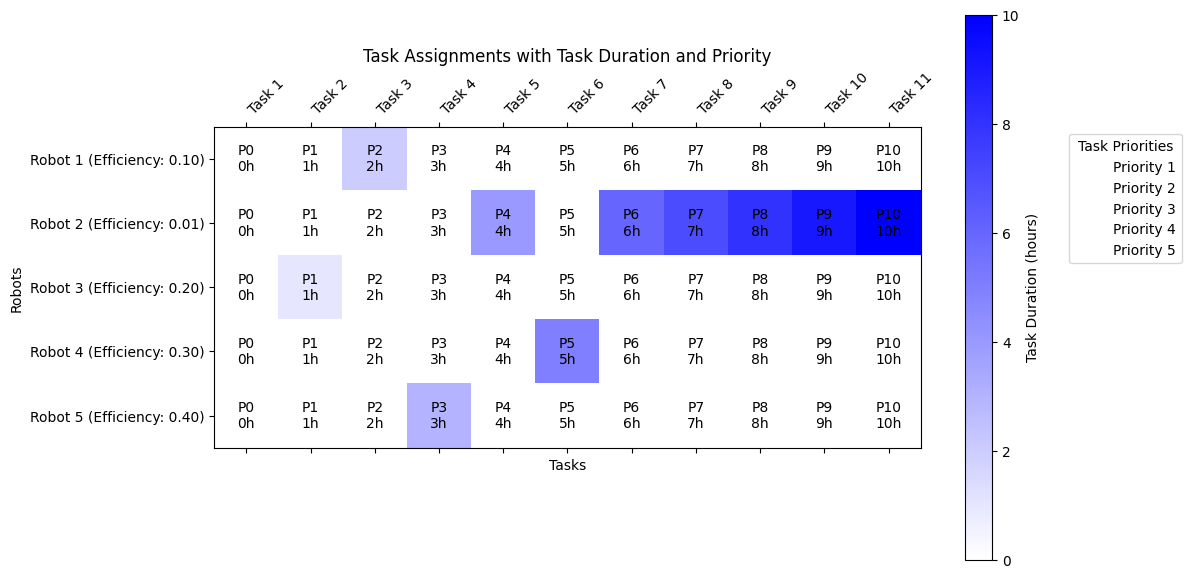

In [734]:
if __name__ == "__main__":
    num_tasks = 10
    num_robots = 5
    task_durations, task_priorities, robot_efficiencies = generate_mock_data()

    # Run GA to find the best solution
    best_solution = run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies)

    # Visualize the initial random assignment
    visualize_assignments_improved(best_solution, task_durations, task_priorities, robot_efficiencies)
